# Insurance cost prediction using linear regression

In this project we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model

In [4]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [5]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [ ]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [ ]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [ ]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [ ]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
803,18,female,48.57600,0,yes,southeast,37628.905032
263,19,male,42.49825,0,yes,northwest,35132.823287
196,39,female,37.72000,0,no,southwest,5480.223550
694,27,female,40.02000,1,no,southwest,3470.659030
37,26,male,23.92000,0,no,southwest,2233.231000


In [ ]:
num_rows = len (dataframe)
print(num_rows)

1271


In [ ]:
num_cols = len (dataframe.columns)
print(num_cols)

7


In [ ]:
# Considering the input columns to be different from target columns

input_cols = []
for cols in dataframe.columns:
  if cols != 'charges':
    input_cols.append(cols)

print (input_cols)

['age', 'sex', 'bmi', 'children', 'smoker', 'region']


In [ ]:
# View column information first

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 803 to 705
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1271 non-null   int64  
 1   sex       1271 non-null   object 
 2   bmi       1271 non-null   float64
 3   children  1271 non-null   int64  
 4   smoker    1271 non-null   object 
 5   region    1271 non-null   object 
 6   charges   1271 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 79.4+ KB


In [ ]:
categorical_cols = dataframe[['sex', 'smoker','region']]

In [ ]:
#output_cols = dataframe.columns[-1]
output_cols = []
for cols in dataframe.columns:
  if cols == 'charges':
    output_cols.append(cols)

print (output_cols)
len (output_cols)

['charges']


1

In [ ]:
dataframe['charges'].describe()

count     1271.000000
mean     12935.616222
std      11830.191055
min       1088.217683
25%       4578.041391
50%       9025.560843
75%      16455.208719
max      61857.315170
Name: charges, dtype: float64

#### Minimm value of the charges column =   1088.217683
#### Maximum value = 61857.315170
#### Average value = 12935.616222



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


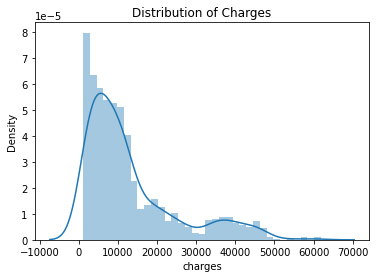

In [ ]:
# Plot showing the distribution of charges

import seaborn as sns
#import matplotlib.pyplot as plt
%matplotlib inline

plt.title ('Distribution of Charges')
sns.distplot(dataframe['charges'], bins=35)

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [ ]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [ ]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array


(array([[18.     ,  0.     , 48.576  ,  0.     ,  1.     ,  2.     ],
        [19.     ,  1.     , 42.49825,  0.     ,  1.     ,  1.     ],
        [39.     ,  0.     , 37.72   ,  0.     ,  0.     ,  3.     ],
        ...,
        [46.     ,  1.     , 43.8955 ,  2.     ,  0.     ,  2.     ],
        [48.     ,  1.     , 40.96875,  4.     ,  0.     ,  0.     ],
        [33.     ,  0.     , 37.835  ,  2.     ,  0.     ,  3.     ]]),
 array([[37628.905032 ],
        [35132.8232865],
        [ 5480.22355  ],
        ...,
        [ 8096.749371 ],
        [10414.7646275],
        [ 5213.78686  ]]))

In [ ]:
inputs = torch.from_numpy(inputs_array).to(torch.float32)
targets = torch.from_numpy(targets_array).to(torch.float32)

In [ ]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [ ]:
dataset = TensorDataset(inputs, targets)

In [ ]:
from torch.utils.data import random_split

val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

# Use the random_split function to split dataset into 2 parts of the desired length

(1081, 190)

In [ ]:
batch_size = 25

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [ ]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[40.0000,  1.0000, 28.8420,  0.0000,  0.0000,  2.0000],
        [36.0000,  1.0000, 32.2287,  1.0000,  1.0000,  0.0000],
        [27.0000,  0.0000, 20.6483,  2.0000,  1.0000,  0.0000],
        [55.0000,  1.0000, 37.5705,  1.0000,  0.0000,  2.0000],
        [57.0000,  0.0000, 33.0050,  0.0000,  0.0000,  3.0000],
        [63.0000,  0.0000, 28.8420,  0.0000,  0.0000,  1.0000],
        [53.0000,  1.0000, 47.6905,  0.0000,  0.0000,  2.0000],
        [62.0000,  0.0000, 36.4895,  0.0000,  0.0000,  0.0000],
        [64.0000,  0.0000, 41.3655,  0.0000,  0.0000,  2.0000],
        [47.0000,  0.0000, 52.1180,  1.0000,  0.0000,  2.0000],
        [38.0000,  0.0000, 22.9425,  2.0000,  0.0000,  0.0000],
        [29.0000,  1.0000, 34.0860,  1.0000,  0.0000,  0.0000],
        [59.0000,  0.0000, 31.8780,  3.0000,  0.0000,  2.0000],
        [21.0000,  0.0000, 40.1005,  0.0000,  0.0000,  2.0000],
        [30.0000,  1.0000, 40.8595,  0.0000,  1.0000,  2.0000],
        [51.0000,  0.0000, 29.67

Let's save our work by committing to Jovian.

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [ ]:
#len(output_cols), len(input_cols)

input_size, output_size

(6, 1)

In [ ]:
input_size = len(input_cols)

output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [ ]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size) # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        #xb = xb.reshape(-1,6)
        out =  self.linear(xb)                        # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss (out, targets)                        # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                          # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [ ]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [ ]:
model.linear

Linear(in_features=6, out_features=1, bias=True)

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0157, -0.3512,  0.3987,  0.0733,  0.1384, -0.1430]],
        requires_grad=True), Parameter containing:
 tensor([-0.2922], requires_grad=True)]

One final commit before we train the model.

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/isahabdul16/02-insurance-linear


'https://jovian.ai/isahabdul16/02-insurance-linear'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [ ]:
# just checking the lengths again
len (val_loader)
model

InsuranceModel(
  (linear): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
result = evaluate (model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 12541.728515625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [ ]:
model = InsuranceModel()
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3581,  0.3557, -0.1386, -0.3482, -0.1884,  0.2954]],
        requires_grad=True), Parameter containing:
 tensor([-0.2713], requires_grad=True)]

In [ ]:
epochs = 100
lr = 0.0005
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 11317.6133
Epoch [40], val_loss: 10140.6465
Epoch [60], val_loss: 9188.2773
Epoch [80], val_loss: 8442.9473
Epoch [100], val_loss: 7914.1235


In [ ]:
epochs = 100
lr = 1e-5
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7905.2803
Epoch [40], val_loss: 7896.4932
Epoch [60], val_loss: 7887.7432
Epoch [80], val_loss: 7879.0137
Epoch [100], val_loss: 7870.5410


In [ ]:
epochs = 100
lr = 1e-6
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7869.2939
Epoch [40], val_loss: 7868.4619
Epoch [60], val_loss: 7867.6353
Epoch [80], val_loss: 7866.8013
Epoch [100], val_loss: 7865.9761


In [ ]:
epochs = 100
lr = 0.0000001
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7865.9482
Epoch [40], val_loss: 7865.9219
Epoch [60], val_loss: 7865.8945
Epoch [80], val_loss: 7865.8672
Epoch [100], val_loss: 7865.8398


In [ ]:
epochs = 100
lr = 0.00000001
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7865.8398
Epoch [40], val_loss: 7865.8398
Epoch [60], val_loss: 7865.8398
Epoch [80], val_loss: 7865.8398
Epoch [100], val_loss: 7865.8398


**Q: What is the final validation loss of your model?**

In [ ]:
val_loss = 7865.8398

Let's log the final validation loss to Jovian and commit the notebook

In [ ]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/isahabdul16/02-insurance-linear


'https://jovian.ai/isahabdul16/02-insurance-linear'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [ ]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)              # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [ ]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([18.0000,  1.0000, 30.0438,  0.0000,  0.0000,  0.0000])
Target: tensor([1657.6580])
Prediction: tensor([3310.7295])


In [ ]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([59.0000,  0.0000, 31.6250,  0.0000,  0.0000,  3.0000])
Target: tensor([11866.8135])
Prediction: tensor([6615.8120])


In [ ]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([54.0000,  1.0000, 24.1615,  2.0000,  0.0000,  2.0000])
Target: tensor([10683.3008])
Prediction: tensor([5755.4170])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [ ]:
jovian.commit(project=project_name, environment=None)
#jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes